In [ ]:
import pandas as pd

# Load data for the selected years (1995-2004)
years = range(1995, 2005)
data_frames = []

for year in years:
    file_path = f"{year}.csv"
    # Sample 5% of the data for each year
    df = pd.read_csv(file_path).sample(frac=0.05, random_state=42)
    data_frames.append(df)

# Concatenate all data frames into a single one
df = pd.concat(data_frames, ignore_index=True)


**Question a**

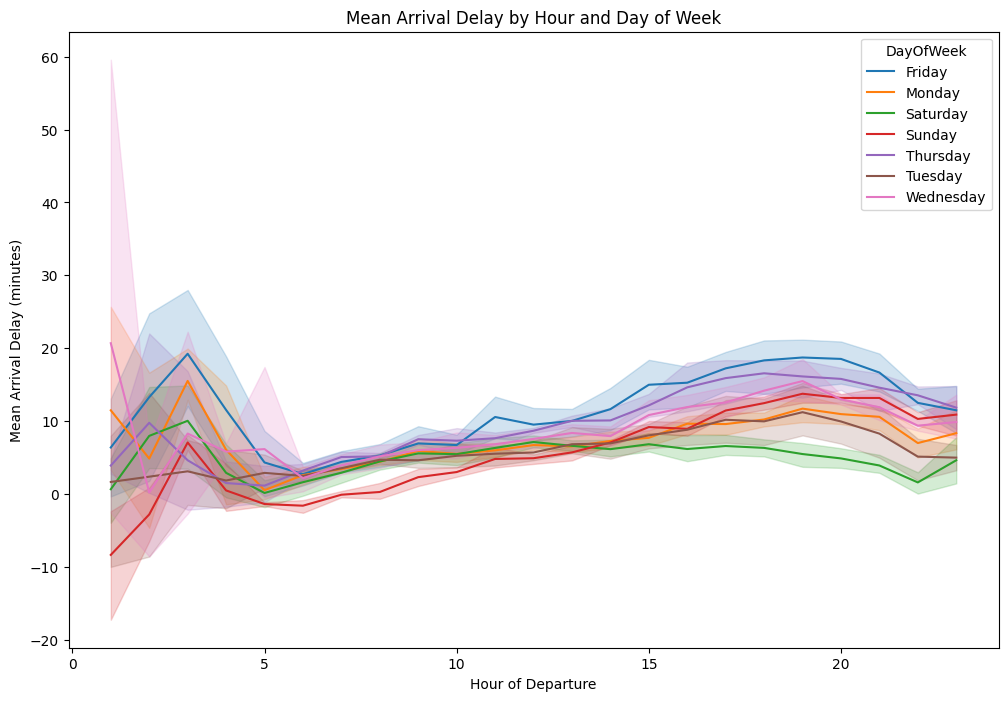

In [ ]:
# Convert times to datetime format
df['CRSDepTime'] = pd.to_datetime(df['CRSDepTime'], format='%H%M', errors='coerce')
df['CRSArrTime'] = pd.to_datetime(df['CRSArrTime'], format='%H%M', errors='coerce')

# Extract hour and day of week
df['DepHour'] = df['CRSDepTime'].dt.hour
df['DayOfWeek'] = df['DayOfWeek'].replace({1: 'Monday', 2: 'Tuesday', 3: 'Wednesday',
                                           4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'})

# Calculate mean delays by hour and day of week
mean_delays = df.groupby(['Year', 'DepHour', 'DayOfWeek'])['ArrDelay'].mean().reset_index()

# Visualize using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.lineplot(x='DepHour', y='ArrDelay', hue='DayOfWeek', data=mean_delays)
plt.title('Mean Arrival Delay by Hour and Day of Week')
plt.xlabel('Hour of Departure')
plt.ylabel('Mean Arrival Delay (minutes)')
plt.show()


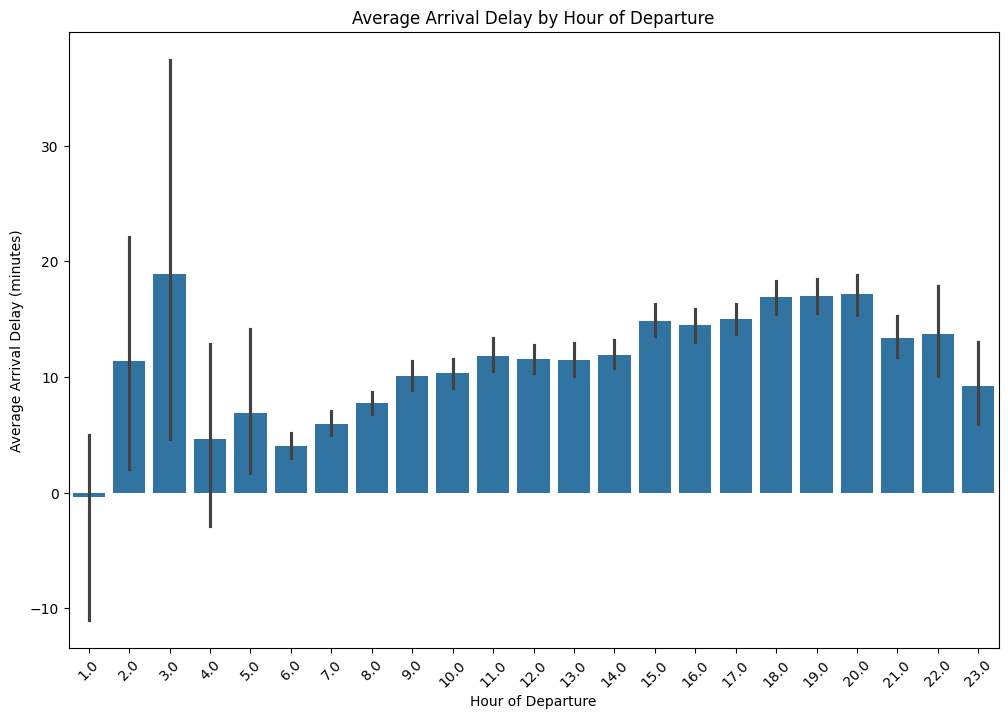

In [ ]:
# Hourly Analysis of Delays

import pandas as pd

df['DepHour'] = df['CRSDepTime'].dt.hour

# Plot average delay by hour of departure
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='DepHour', y='ArrDelay', data=df)
plt.title('Average Arrival Delay by Hour of Departure')
plt.xlabel('Hour of Departure')
plt.ylabel('Average Arrival Delay (minutes)')
plt.xticks(rotation=45)
plt.show()


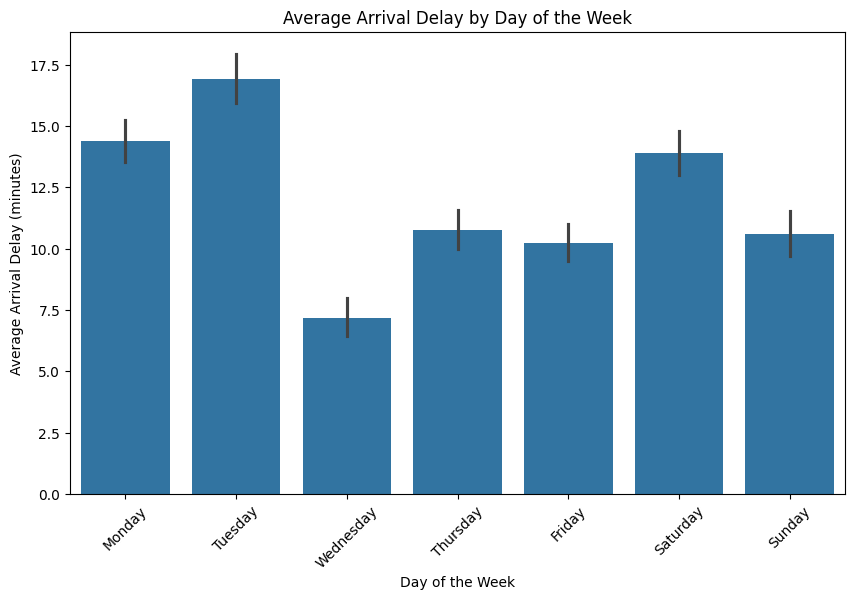

In [ ]:
# Day-of-Week Analysis of Delays

import numpy as np

# Plot average delay by day of the week
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))
sns.barplot(x='DayOfWeek', y='ArrDelay', data=df, estimator=np.mean)
plt.title('Average Arrival Delay by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Arrival Delay (minutes)')
plt.xticks(ticks=range(7), labels=weekday_labels, rotation=45)
plt.show()


**Question b**

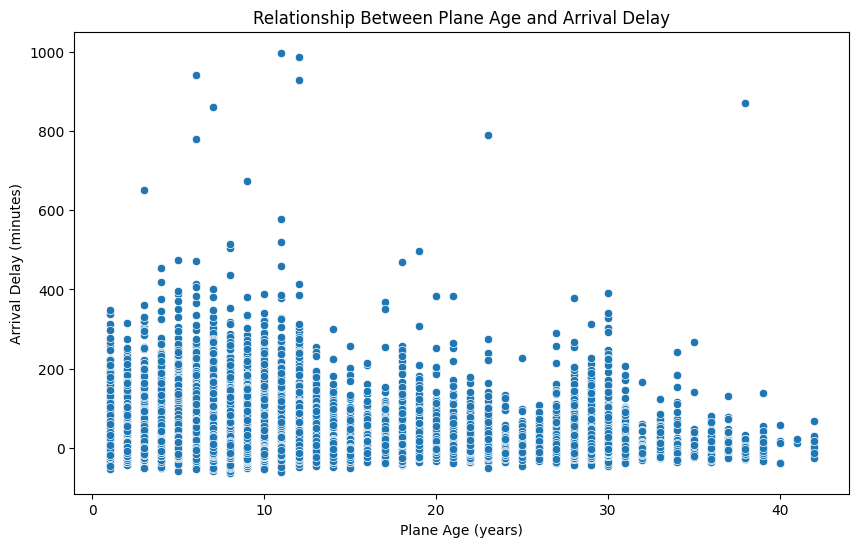

In [ ]:
# Merge with plane data to get plane year information
plane_data = pd.read_csv('plane-data.csv')

# Convert 'issue_date' column to datetime format
plane_data['issue_date'] = pd.to_datetime(plane_data['issue_date'])
plane_data['AircraftYear'] = plane_data['issue_date'].dt.year

plane_data = plane_data.dropna()


# Merge with tail number
df_merged = df.merge(plane_data[['tailnum', 'year']], left_on='TailNum', right_on='tailnum', how='left')

# Calculate age of plane
df_merged['PlaneAge'] = df_merged['Year'] - df_merged['year']

# Clean the data (remove NA and erroneous data)
df_merged = df_merged[['PlaneAge', 'ArrDelay']].dropna()
df_merged = df_merged[df_merged['PlaneAge'] > 0]

# Plot relationship between plane age and delays
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PlaneAge', y='ArrDelay', data=df_merged)
plt.title('Relationship Between Plane Age and Arrival Delay')
plt.xlabel('Plane Age (years)')
plt.ylabel('Arrival Delay (minutes)')
plt.show()


Coefficient of Plane Age: -0.14380028223245067
Mean Squared Error: 1193.9929756717415
R^2 Score: 0.00019504017058558087


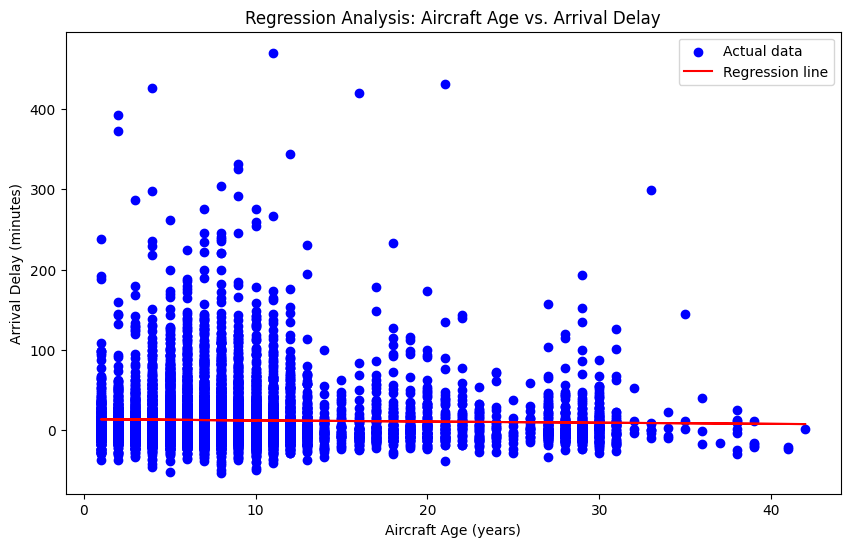

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Prepare data for regression analysis
X = df_merged[['PlaneAge']]
y = df_merged['ArrDelay']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions using the model
y_pred = model.predict(X_test)

# Print coefficient of aircraft age
print(f"Coefficient of Plane Age: {model.coef_[0]}")

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plot regression line
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Actual data')
plt.plot(X_train, model.predict(X_train), color='red', label='Regression line')
plt.title('Regression Analysis: Aircraft Age vs. Arrival Delay')
plt.xlabel('Aircraft Age (years)')
plt.ylabel('Arrival Delay (minutes)')
plt.legend()
plt.show()


**Question c**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

import pandas as pd
from pandasql import sqldf

airports_df = pd.read_csv('airports.csv')
# Merge flights data with airports data to filter flights within the USA
flights_usa = pd.merge(df, airports_df, left_on='Origin', right_on='iata', suffixes=('', '_origin'))
flights_usa = pd.merge(flights_usa, airports_df, left_on='Dest', right_on='iata', suffixes=('', '_dest'))

# Filter flights within the USA
flights_usa = flights_usa[(flights_usa['country'] == 'USA') & (flights_usa['country_dest'] == 'USA')]

# Drop redundant columns
flights_usa = flights_usa.drop(['country_dest'], axis=1)


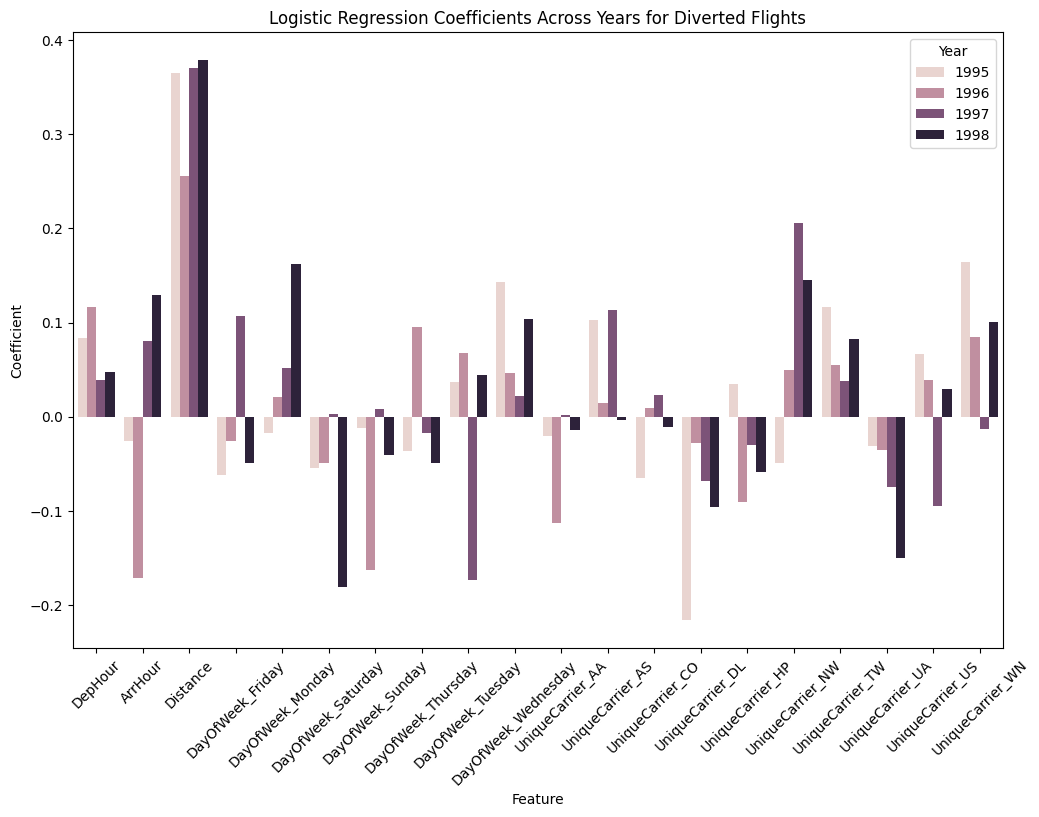

In [ ]:
# Select relevant features
flights_usa['ArrHour'] = flights_usa['CRSArrTime'].dt.hour
features = ['DayOfWeek', 'DepHour', 'ArrHour', 'Distance', 'UniqueCarrier', 'Year', 'Diverted']
df_subset = flights_usa[features].dropna()

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_subset, columns=['DayOfWeek', 'UniqueCarrier'])

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded.drop(['Year', 'Diverted'], axis=1))

# Initialize coefficients dataframe
coefficients = pd.DataFrame()

# Fit logistic regression model for each year
years = df_encoded['Year'].unique()

for year in years:
    # Filter data for the current year
    year_data = df_encoded[df_encoded['Year'] == year]

    if year_data.shape[0] == 0:
        continue  # Skip if no data for the current year

    X_year = X_scaled[df_encoded['Year'] == year]
    y_year = year_data['Diverted']

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_year, y_year, test_size=0.2, random_state=42)

    # Fit logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Store coefficients for visualization
    coeffs = pd.DataFrame({'Feature': df_encoded.drop(['Year', 'Diverted'], axis=1).columns, 'Coefficient': model.coef_[0]})
    coeffs['Year'] = year
    coefficients = pd.concat([coefficients, coeffs])

# Visualize coefficients across years
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.barplot(x='Feature', y='Coefficient', hue='Year', data=coefficients)
plt.title('Logistic Regression Coefficients Across Years for Diverted Flights')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.show()


In [ ]:
df['ArrHour'] = df['CRSArrTime'].dt.hour

0         21.0
1          7.0
2         20.0
3          8.0
4         16.0
          ... 
463633    15.0
463634    19.0
463635    22.0
463636    22.0
463637    14.0
Name: CRSArrTime, Length: 463638, dtype: float64